In [93]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision.transforms import ToTensor
from config import *
from itertools import chain
import copy

In [3]:
train_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train = False, download = True, transform = ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def kldivergence()

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

In [6]:
def train_vae_gen(vae, train_dataloader, sample_vae=False, sample_from=None, grad_noise=False, debug=False):
    vae = vae.to(device)

    if debug:
        num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

    vae.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            if sample_vae:
                with torch.no_grad():
                    # image_batch = image_batch.to(device)
                    latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
                    image_batch = sample_from.decoder(latent)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            if grad_noise:
                for p in vae.parameters():
                    p.grad = p.grad + torch.randn_like(p.grad) * ng_stdev

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [30]:
def discriminator_loss(y_pred, y):
    return F.binary_cross_entropy(y_pred.view(-1), y, reduction="sum")

In [108]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_z = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_y = nn.Linear(in_features=latent_dims, out_features=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        xl = x
        z = F.relu(self.fc_z(x))
        y = torch.sigmoid(self.fc_y(z))
        return y, xl

In [89]:
def train_discriminator(disc, train_dataloader, debug=False):
    disc = disc.to(device)

    if debug:
        num_params = sum(p.numel() for p in disc.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=disc.parameters(), lr=learning_rate, weight_decay=1e-5)

    disc.train()

    train_loss_avg = []
    train_acc_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        train_acc_avg.append(0)
        num_batches = 0
        
        for image_batch, y in train_dataloader:

            image_batch = image_batch.to(device)

            # vae reconstruction
            y_pred = disc(image_batch)

            # reconstruction error
            loss = discriminator_loss(y_pred, y)
            

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            train_acc_avg[-1] += torch.sum(torch.round(y_pred.view(-1)) == y) / batch_size
            
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        train_acc_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
            print('average accuracy: %f' % (train_acc_avg[-1]))

In [10]:
vae = VariationalAutoencoder().to(device)

In [12]:
train_vae_gen(vae, train_dataloader, debug=True)

Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 42270.152552
Epoch [2 / 30] average reconstruction error: 29414.577493
Epoch [3 / 30] average reconstruction error: 28024.378229
Epoch [4 / 30] average reconstruction error: 27398.030178
Epoch [5 / 30] average reconstruction error: 27006.551758
Epoch [6 / 30] average reconstruction error: 26717.592686
Epoch [7 / 30] average reconstruction error: 26523.797469
Epoch [8 / 30] average reconstruction error: 26374.526862
Epoch [9 / 30] average reconstruction error: 26251.159159
Epoch [10 / 30] average reconstruction error: 26125.846160
Epoch [11 / 30] average reconstruction error: 26035.969132
Epoch [12 / 30] average reconstruction error: 25950.887724
Epoch [13 / 30] average reconstruction error: 25853.971505
Epoch [14 / 30] average reconstruction error: 25783.171767
Epoch [15 / 30] average reconstruction error: 25711.938410
Epoch [16 / 30] average reconstruction error: 25652.293434
Epoch [17 / 30] average

In [38]:
latent = torch.randn(30000, latent_dims, device=device)
x_recon = vae.decoder(latent).clone().detach() #don't clone and detach for vae_gan
fake_dataset = TensorDataset(x_recon, torch.zeros(30000).to(device))

latent = torch.randn(5000, latent_dims, device=device)
x_recon = vae.decoder(latent).clone().detach() #don't clone and detach for vae_gan
fake_test = TensorDataset(x_recon, torch.zeros(5000).to(device))

In [39]:
real_dataloader = DataLoader(train_dataset, batch_size=30000, shuffle=True)
x = next(iter(real_dataloader))[0].to(device)
y = torch.ones(30000).to(device)
real_dataset = TensorDataset(x, y)

real_dataloader = DataLoader(test_dataset, batch_size=5000, shuffle=True)
x = next(iter(real_dataloader))[0].to(device)
y = torch.ones(5000).to(device)
real_test = TensorDataset(x, y)

In [41]:
discriminator_dataset = ConcatDataset([fake_dataset, real_dataset])
discriminator_dataloader = DataLoader(discriminator_dataset, batch_size=batch_size, shuffle=True)

discriminator_testset = ConcatDataset([fake_test, real_test])
discriminator_testloader = DataLoader(discriminator_testset, batch_size=batch_size, shuffle=True)

In [104]:
discrim = Discriminator().to(device)
train_discriminator(discrim, discriminator_dataloader, debug=True)

Number of parameters: 138561
Training ...
Epoch [1 / 30] average reconstruction error: 51.568659
average accuracy: 0.916489
Epoch [2 / 30] average reconstruction error: 12.694222
average accuracy: 0.982846
Epoch [3 / 30] average reconstruction error: 8.602951
average accuracy: 0.987683
Epoch [4 / 30] average reconstruction error: 35.774054
average accuracy: 0.968085
Epoch [5 / 30] average reconstruction error: 7.018751
average accuracy: 0.990326
Epoch [6 / 30] average reconstruction error: 5.421053
average accuracy: 0.991572
Epoch [7 / 30] average reconstruction error: 4.777436
average accuracy: 0.992237
Epoch [8 / 30] average reconstruction error: 4.570286
average accuracy: 0.992320
Epoch [9 / 30] average reconstruction error: 4.667233
average accuracy: 0.991971
Epoch [10 / 30] average reconstruction error: 4.347723
average accuracy: 0.992038
Epoch [11 / 30] average reconstruction error: 3.595678
average accuracy: 0.993168
Epoch [12 / 30] average reconstruction error: 4.180076
average

In [91]:
train_acc_avg = 0
num_batches = 0

for image_batch, y in discriminator_testloader:

    image_batch = image_batch.to(device)

    # vae reconstruction
    y_pred = disc(image_batch)

    train_acc_avg += torch.sum(torch.round(y_pred.view(-1)) == y) / batch_size
    
    num_batches += 1
train_acc_avg /= num_batches

print(f"Accuracy avg: {train_acc_avg}")

Accuracy avg: 0.9750000238418579


In [119]:
# https://arxiv.org/pdf/1512.09300
# https://github.com/rishabhd786/VAE-GAN-PYTORCH/blob/master/main.py
from torch.autograd import Variable

alpha = 0.1
gamma=15

vae = VariationalAutoencoder().to(device)
discrim = Discriminator().to(device)

criterion=nn.BCELoss().to(device)
optim_E=torch.optim.RMSprop(vae.encoder.parameters(), lr=learning_rate)
optim_D=torch.optim.RMSprop(vae.decoder.parameters(), lr=learning_rate)
optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=learning_rate*alpha)

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
    dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
    for i, (data,_) in enumerate(train_dataloader, 0):
        bs=data.size()[0]
        
        ones_label=Variable(torch.ones(bs,1)).to(device)
        zeros_label=Variable(torch.zeros(bs,1)).to(device)
        zeros_label1=Variable(torch.zeros(64,1)).to(device)
        datav = Variable(data).to(device)
        rec_enc, mean, logvar = vae(datav)
        z_p = Variable(torch.randn(64,latent_dims)).to(device)
        x_p_tilda = vae.decoder(z_p)
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        dis_real_list.append(errD_real.item())
        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())
        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        dis_prior_list.append(errD_rec_noise.item())
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        gan_loss_list.append(gan_loss.item())
        optim_Dis.zero_grad()
        gan_loss.backward(retain_graph=True)
        optim_Dis.step()
        
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        
        
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        err_dec = gamma * rec_loss - gan_loss 
        recon_loss_list.append(rec_loss.item())
        optim_D.zero_grad()
        err_dec.backward(retain_graph=True)
        optim_D.step()
        
        rec_enc, mean, logvar = vae(datav)
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
        prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + 5*rec_loss
        
        optim_E.zero_grad()
        err_enc.backward(retain_graph=True)
        optim_E.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


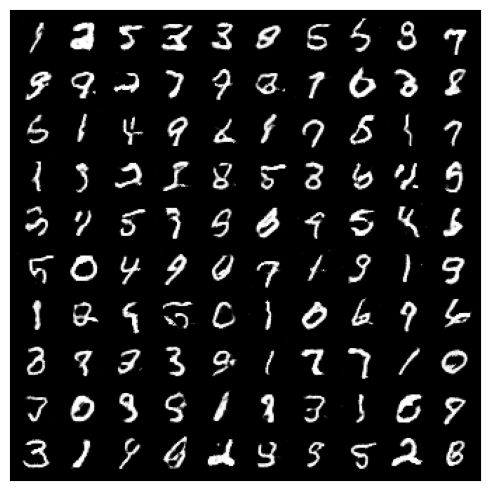

In [124]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = vae.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [125]:
from vae_model import collapse

samples = []
loss = []
collapse(vae, vae, samples, loss, debug=True)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19


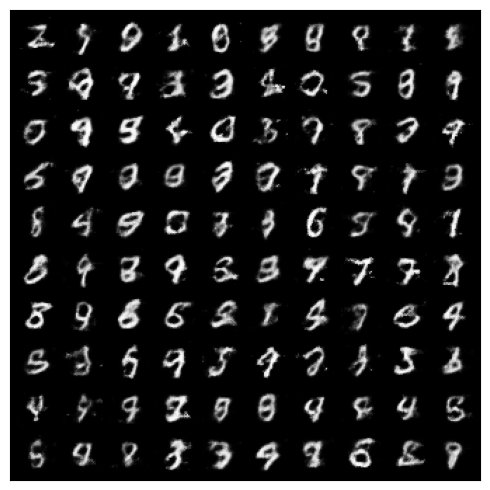

In [129]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(samples[3].data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()